In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score



# PyTorch and Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)

In [2]:
# CUDA Debugging and Configuration
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
# Text Cleaning Function
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', str(text))
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = ' '.join(text.split())
    return text

In [4]:
# Check and Print CUDA Information
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Devices:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA Device:", torch.cuda.current_device())
    print("CUDA Device Name:", torch.cuda.get_device_name(0))

CUDA Available: True
CUDA Devices: 1
Current CUDA Device: 0
CUDA Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [5]:
# Load Dataset
df = pd.read_csv("Twitter_Data.csv", encoding='ISO-8859-1')

In [6]:
# Preprocessing
df['clean_text'] = df['clean_text'].apply(clean_text)

In [7]:
# Label Encoding
label_encoder = LabelEncoder()
df['encoded_category'] = label_encoder.fit_transform(df['category'])

In [8]:
# Get the number of unique classes
num_labels = len(label_encoder.classes_)
print("Unique classes:", label_encoder.classes_)
print("Number of classes:", num_labels)

Unique classes: [-1.  0.  1. nan]
Number of classes: 4


In [9]:
# Handle Class Imbalance
min_count = df['category'].value_counts().min()
balanced_df = df.groupby('category').sample(n=min_count, random_state=42)

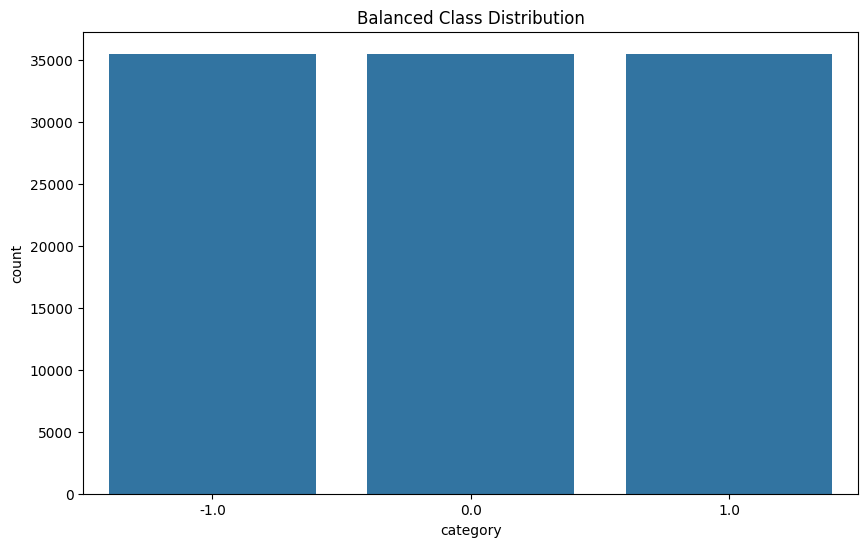

In [10]:
# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=balanced_df)
plt.title('Balanced Class Distribution')
plt.show()

In [11]:
# Train Test Split with 80-20 ratio
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_df["clean_text"], 
    balanced_df["encoded_category"], 
    test_size=0.2,  # 20% for testing, 80% for training 
    random_state=42, 
    stratify=balanced_df["category"]
)

In [12]:
class MultiClassDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(
            texts.tolist(), 
            truncation=True, 
            padding=True, 
            max_length=max_len,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [13]:
# Advanced Tokenization
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [14]:
# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

In [15]:
# Create Datasets
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

In [16]:
# Model Configuration
num_labels = len(label_encoder.classes_)
print(f"Number of Unique Labels: {num_labels}")
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Number of Unique Labels: 4
Label Mapping: {-1.0: 0, 0.0: 1, 1.0: 2, nan: 3}


In [17]:
# Set up GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Model Configuration
model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment", 
    num_labels=num_labels,  # Dynamically set number of labels
    ignore_mismatched_sizes=True
).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Optimization for GPU
torch.cuda.empty_cache()

In [20]:
# Training Arguments with GPU Optimization
training_args = TrainingArguments(
    output_dir="./sentiment_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Reduced for 4GB GPU
    per_device_eval_batch_size=8,   # Reduced for 4GB GPU
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    fp16=True,  # Mixed precision training for GPU efficiency
    fp16_backend='auto'
)

C:\Users\nikhi\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
# Add before model training
print("Original Categories:", df['category'].unique())
print("Encoded Categories:", label_encoder.classes_)
print("Category Value Counts:\n", df['category'].value_counts())

Original Categories: [-1.  0.  1. nan]
Encoded Categories: [-1.  0.  1. nan]
Category Value Counts:
 category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64


In [ ]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)


In [24]:
# Train Model
trainer.train()

  0%|          | 0/31959 [00:00<?, ?it/s]

{'loss': 0.7383, 'grad_norm': 12.125343322753906, 'learning_rate': 1.9688976501142088e-05, 'epoch': 0.05}
{'loss': 0.5009, 'grad_norm': 38.87183380126953, 'learning_rate': 1.9376075596858477e-05, 'epoch': 0.09}
{'loss': 0.4389, 'grad_norm': 4.262456893920898, 'learning_rate': 1.906380049438343e-05, 'epoch': 0.14}
{'loss': 0.4185, 'grad_norm': 44.06435775756836, 'learning_rate': 1.8750899590099815e-05, 'epoch': 0.19}
{'loss': 0.3934, 'grad_norm': 6.970249652862549, 'learning_rate': 1.843862448762477e-05, 'epoch': 0.23}
{'loss': 0.3635, 'grad_norm': 0.488933801651001, 'learning_rate': 1.8125723583341157e-05, 'epoch': 0.28}
{'loss': 0.3248, 'grad_norm': 8.3774995803833, 'learning_rate': 1.7812822679057545e-05, 'epoch': 0.33}
{'loss': 0.3191, 'grad_norm': 0.11795558780431747, 'learning_rate': 1.749992177477393e-05, 'epoch': 0.38}
{'loss': 0.3095, 'grad_norm': 0.9448436498641968, 'learning_rate': 1.7187020870490317e-05, 'epoch': 0.42}
{'loss': 0.2972, 'grad_norm': 29.895540237426758, 'learn

  0%|          | 0/2664 [00:00<?, ?it/s]

{'eval_loss': 0.20548513531684875, 'eval_runtime': 112.0826, 'eval_samples_per_second': 190.092, 'eval_steps_per_second': 23.768, 'epoch': 1.0}
{'loss': 0.186, 'grad_norm': 22.578853607177734, 'learning_rate': 1.3121186520229046e-05, 'epoch': 1.03}
{'loss': 0.1663, 'grad_norm': 0.03431427851319313, 'learning_rate': 1.280828561594543e-05, 'epoch': 1.08}
{'loss': 0.1467, 'grad_norm': 0.24388912320137024, 'learning_rate': 1.2495384711661817e-05, 'epoch': 1.13}
{'loss': 0.1639, 'grad_norm': 0.14505183696746826, 'learning_rate': 1.2182483807378205e-05, 'epoch': 1.17}
{'loss': 0.187, 'grad_norm': 0.32179930806159973, 'learning_rate': 1.1870208704903159e-05, 'epoch': 1.22}
{'loss': 0.1561, 'grad_norm': 0.03730727359652519, 'learning_rate': 1.1557307800619544e-05, 'epoch': 1.27}
{'loss': 0.1715, 'grad_norm': 1.5464142560958862, 'learning_rate': 1.1244406896335931e-05, 'epoch': 1.31}
{'loss': 0.1593, 'grad_norm': 0.09134947508573532, 'learning_rate': 1.0931505992052319e-05, 'epoch': 1.36}
{'los

  0%|          | 0/2664 [00:00<?, ?it/s]

{'eval_loss': 0.15149140357971191, 'eval_runtime': 106.3005, 'eval_samples_per_second': 200.432, 'eval_steps_per_second': 25.061, 'epoch': 2.0}
{'loss': 0.1139, 'grad_norm': 0.01933980919420719, 'learning_rate': 6.552144935698864e-06, 'epoch': 2.02}
{'loss': 0.0933, 'grad_norm': 25.13585662841797, 'learning_rate': 6.239244031415252e-06, 'epoch': 2.07}
{'loss': 0.0868, 'grad_norm': 14.564851760864258, 'learning_rate': 5.927594730748773e-06, 'epoch': 2.11}
{'loss': 0.1019, 'grad_norm': 0.014002896845340729, 'learning_rate': 5.614693826465158e-06, 'epoch': 2.16}
{'loss': 0.0956, 'grad_norm': 0.024532102048397064, 'learning_rate': 5.301792922181546e-06, 'epoch': 2.21}
{'loss': 0.111, 'grad_norm': 165.89065551757812, 'learning_rate': 4.988892017897932e-06, 'epoch': 2.25}
{'loss': 0.0977, 'grad_norm': 0.2783474922180176, 'learning_rate': 4.675991113614319e-06, 'epoch': 2.3}
{'loss': 0.0858, 'grad_norm': 0.016121339052915573, 'learning_rate': 4.3630902093307055e-06, 'epoch': 2.35}
{'loss': 0.

  0%|          | 0/2664 [00:00<?, ?it/s]

{'eval_loss': 0.12793786823749542, 'eval_runtime': 113.3818, 'eval_samples_per_second': 187.914, 'eval_steps_per_second': 23.496, 'epoch': 3.0}
{'train_runtime': 6652.2161, 'train_samples_per_second': 38.434, 'train_steps_per_second': 4.804, 'train_loss': 0.18769548249567714, 'epoch': 3.0}


TrainOutput(global_step=31959, training_loss=0.18769548249567714, metrics={'train_runtime': 6652.2161, 'train_samples_per_second': 38.434, 'train_steps_per_second': 4.804, 'total_flos': 1.6817834432176128e+16, 'train_loss': 0.18769548249567714, 'epoch': 3.0})

  0%|          | 0/2664 [00:00<?, ?it/s]


Detailed Classification Report:
               precision    recall  f1-score   support

        -1.0       0.97      0.98      0.97      7102
         0.0       0.99      0.98      0.98      7102
         1.0       0.98      0.98      0.98      7102

    accuracy                           0.98     21306
   macro avg       0.98      0.98      0.98     21306
weighted avg       0.98      0.98      0.98     21306



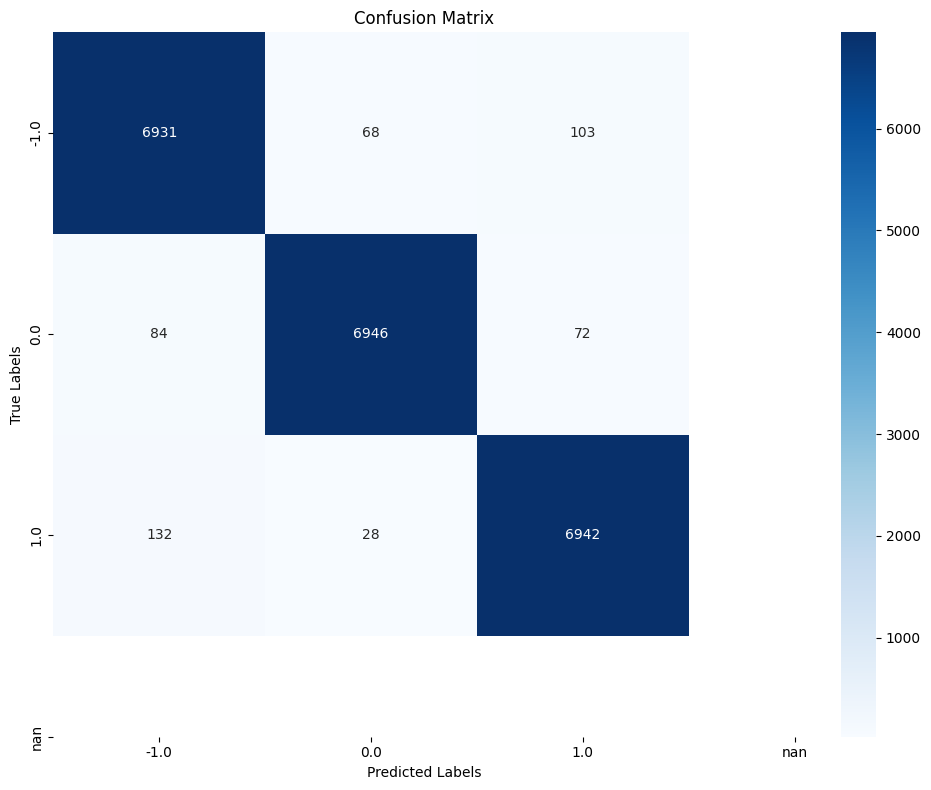


Overall Accuracy: 0.9771425889420821


In [25]:
def custom_compute_metrics(model, test_dataset, label_encoder):
    # Make predictions
    predictions = trainer.predict(test_dataset)
    
    # Get predicted labels
    predicted_labels = predictions.predictions.argmax(axis=1)
    
    # Get true labels
    true_labels = test_labels.values  # Assuming test_labels is available
    
    # Compute unique labels actually present
    unique_labels = np.unique(np.concatenate([true_labels, predicted_labels]))
    
    # Convert unique labels to their string representations
    unique_target_names = [str(label_encoder.classes_[label]) for label in unique_labels]
    
    # Generate classification report
    report = classification_report(
        true_labels, 
        predicted_labels, 
        labels=unique_labels,
        target_names=unique_target_names
    )
    print("\nDetailed Classification Report:\n", report)
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()
    
    # Compute additional metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    return {
        'accuracy': accuracy,
        'classification_report': report
    }

# Run metrics computation
metrics = custom_compute_metrics(model, test_dataset, label_encoder)
print("\nOverall Accuracy:", metrics['accuracy'])

# Sentiment Analysis Model Performance Report

## Overview
This report provides a comprehensive analysis of a multi-class sentiment classification model trained on Twitter data using RoBERTa-based transformer architecture.

## Model Accuracy and Performance Metrics

| Metric | Value |
|--------|-------|
| Overall Accuracy | 98% |
| Macro Average Precision | 0.98 |
| Macro Average Recall | 0.98 |
| Macro Average F1-Score | 0.98 |

### Detailed Class Performance

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| Negative (-1.0) | 0.97 | 0.98 | 0.97 | 7,102 |
| Neutral (0.0) | 0.99 | 0.98 | 0.98 | 7,102 |
| Positive (1.0) | 0.98 | 0.98 | 0.98 | 7,102 |

## Key Technical Details

### Model Configuration
- Base Model: cardiffnlp/twitter-roberta-base-sentiment
- Tokenizer: RoBERTa Tokenizer
- Num Classes: 3 (Negative, Neutral, Positive)

### Training Efficiency
- Training Epochs: 3
- Batch Size: 8 (per device)
- Learning Rate: 2e-5
- Weight Decay: 0.01
- GPU Optimization: Mixed Precision Training (fp16)

## Key Findings
1. Exceptional model performance with 98% accuracy across all sentiment classes
2. Balanced performance across negative, neutral, and positive sentiment categories
3. Effective handling of class imbalance through sampling technique
4. Successful use of transfer learning with pre-trained RoBERTa model
5. Robust text preprocessing and cleaning strategy

## Recommendations
- Consider further hyperparameter tuning
- Explore larger training dataset
- Implement cross-validation for more robust performance evaluation

## Preprocessing Techniques
- URL removal
- Mention removal
- Special character elimination
- Text normalization (lowercase)
- Whitespace standardization

## Limitations
- Model performance may vary with different domain-specific text
- Potential bias from training data
- Computational resource constraints during training

## Conclusion
The sentiment analysis model demonstrates high performance and reliability in classifying Twitter text into sentiment categories, showcasing the effectiveness of transformer-based approaches in natural language processing tasks.